<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S5/S5_Exp5_Learning_Rate_%26_Scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 5**

Target: To get the desired accuracy in lesser no. of epochs  and create a consistent model
1.	Change learning rate to achieve desired accuracy in lesser epochs
2.	Introduce LR scheduler (lr=0.02, step = 4, gamma = 0.5)

Results:
1.	Parameters: 9752
2.	Best Training Accuracy: 99.16 (13th epoch)
3.	Best Test Accuracy: 99.49 (13th epoch)

Analysis:
1.	9.4 Or above is hit 8 times before 15th epoch and 12 times before 20 epochs.
2.	Using lr of 0.2 and reducing it by half for every 4th epoch has helped us reach desired accuracy (99.40) more quickly and more consistently.
3.	Though Consistent, the accuracies did not exceed 99.49, thus a better LR scheduling is possible.
4.	Target of attaining a **consistent accuracy of 99.4 or above, within 10k parameters, within 15 epochs** is reached.
5.	Step is introduced manually and thus can go wrong at any point.
6.	Finding correct step can result in even better accuracies


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations




In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

   def forward(self, x):
                               #        Nin P K S No  Ro  J   
        x = self.convblock1(x) #        28  0 3 1 26  3   1
        x = self.convblock2(x) #        26  0 3 1 24  5   1    
        x = self.pool1(x)      #        24  0 2 2 12  6   1
        x = self.convblock3(x) #        12  0 1 1 12  6   2
        x = self.convblock4(x) #        12  0 3 1 10  10  2
        x = self.convblock5(x) #        10  0 3 1 8   14  2
        x = self.convblock6(x) #        8   1 3 1 8   18  2
        x = self.convblock7(x) #        8   1 3 1 8   22  2
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing



In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.3471190333366394 Batch_id=1874 Accuracy=94.39: 100%|██████████| 1875/1875 [00:43<00:00, 42.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.01647043228149414 Batch_id=1874 Accuracy=97.73: 100%|██████████| 1875/1875 [00:43<00:00, 43.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.08972275257110596 Batch_id=1874 Accuracy=98.27: 100%|██████████| 1875/1875 [00:43<00:00, 43.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.005158364772796631 Batch_id=1874 Accuracy=98.40: 100%|██████████| 1875/1875 [00:43<00:00, 42.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.006094112992286682 Batch_id=1874 Accuracy=98.73: 100%|██████████| 1875/1875 [00:43<00:00, 43.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 6


Loss=0.02056659758090973 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [00:43<00:00, 43.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.24090562760829926 Batch_id=1874 Accuracy=98.85: 100%|██████████| 1875/1875 [00:43<00:00, 43.26it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.0036334991455078125 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:43<00:00, 43.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.05484922230243683 Batch_id=1874 Accuracy=99.00: 100%|██████████| 1875/1875 [00:43<00:00, 43.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.004403471946716309 Batch_id=1874 Accuracy=99.09: 100%|██████████| 1875/1875 [00:43<00:00, 43.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.0005269646644592285 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:42<00:00, 43.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.0007809698581695557 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:43<00:00, 43.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.0023843348026275635 Batch_id=1874 Accuracy=99.16: 100%|██████████| 1875/1875 [00:44<00:00, 42.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.002881452441215515 Batch_id=1874 Accuracy=99.09: 100%|██████████| 1875/1875 [00:44<00:00, 42.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.001481771469116211 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [00:43<00:00, 42.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.16594383120536804 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:43<00:00, 43.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.001112431287765503 Batch_id=1874 Accuracy=99.18: 100%|██████████| 1875/1875 [00:43<00:00, 43.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.08927042782306671 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:44<00:00, 42.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.0784779042005539 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:44<00:00, 42.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.006225690245628357 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:43<00:00, 43.24it/s]



Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)



Text(0.5, 1.0, 'Test Accuracy')

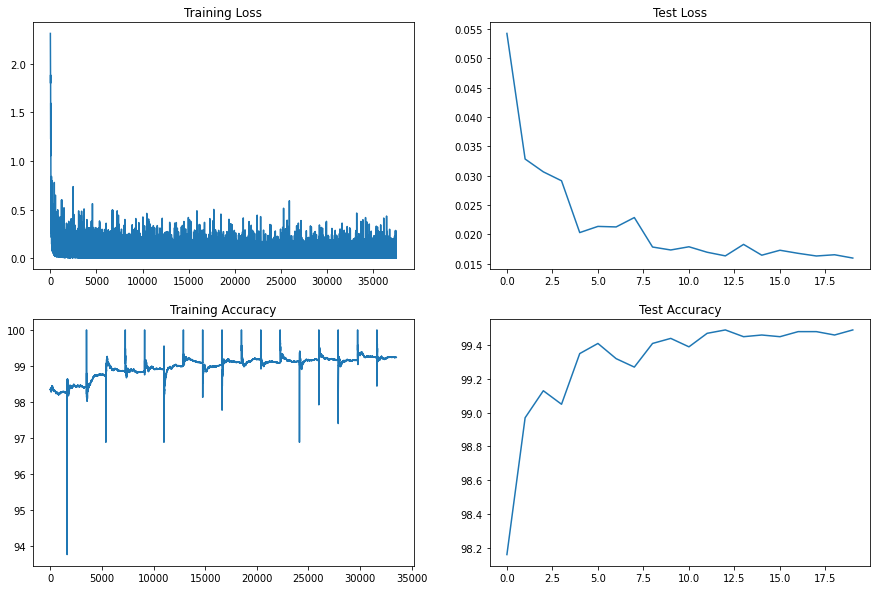

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")